In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv004.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023


In [2]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# MICCAI 2023 phantom experiment

In [3]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023'

In [ ]:
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=bio170034p
#SBATCH --partition=BatComputer
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/MRE-PINN

python ../../../train.py \\
    --xarray_dir {xarray_dir} \\
    --example_id {example_id} \\
    --frequency {frequency} \\
    --noise_ratio {noise_ratio} \\
    --omega {omega} \\
    --polar_input {polar_input} \\
    --savgol_filter {savgol_filter} \\
    --pde_name {pde_name} \\
    --pde_warmup_iters 10000 \\
    --pde_step_iters 5000 \\
    --pde_step_factor 10 \\
    --pde_init_weight {pde_init_weight} \\
    --pde_loss_weight {pde_loss_weight} \\
    --a_loss_weight {a_loss_weight} \\
    --anatomical {anatomical} \\
    --n_iters {n_iters} \\
    --save_prefix {job_name}    
'''
name = 'train_{data_name}_{example_id}_{savgol_filter}_{pde_name}'

param_space = ps.ParamSpace(
    data_name='phantom',
    xarray_dir='../../../data/BIOQIC/phantom',
    example_id=[30, 40, 50, 60, 70, 80, 90, 100],
    frequency='auto',
    noise_ratio=0.0,
    omega=[60],
    polar_input=0,
    pde_name=['helmholtz', 'hetero'],
    savgol_filter=[0, 1],
    pde_init_weight=1e-12,
    pde_loss_weight=1e-10,
    a_loss_weight=[0],
    anatomical=True,
    n_iters=1,
)

len(param_space)

In [ ]:
name.format(**list(param_space)[0])

In [ ]:
%autoreload
expt_name = '2023-2-26_phantom_FEM'

#jobs = ps.submit(template, name, list(param_space), work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

jobs = pd.read_csv(f'{expt_name}.jobs')

In [ ]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
status = ps.status(jobs, parse=True)[status_cols]
status

In [ ]:
status['has_error'] = ~status.stderr.isnull()
status['python_error'] = status.stderr.astype(str).str.contains('python: command not found')

status.fillna('DONE').groupby(['job_state', 'has_error', 'python_error'])[['job_name']].count()

In [4]:
pinn_jobs = pd.read_csv(f'2022-2-7_phantom_anat2.jobs', index_col=0)
fem_jobs = pd.read_csv(f'2023-2-26_phantom_FEM.jobs', index_col=0)

param_cols = ['pde_name', 'example_id', 'omega', 'a_loss_weight', 'savgol_filter'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV', 'R'] # metric values

pinn_metrics = ps.metrics(pinn_jobs)
pinn_metrics['savgol_filter'] = 0

pinn_metrics_sg = pinn_metrics.copy()
pinn_metrics_sg['savgol_filter'] = 1

pinn_metrics = pd.concat([pinn_metrics, pinn_metrics_sg])

fem_metrics = ps.metrics(fem_jobs)
fem_metrics.iteration *= 100000

In [5]:
param_cols = ['pde_name', 'example_id', 'omega', 'a_loss_weight', 'savgol_filter'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV', 'R'] # metric values

def metric_map(tup):
    metric_name, var_name = tup
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('pde_diff_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

def format_metrics(metrics):
    metrics = metrics[metrics.iteration == 100e3]
    metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean()
    metrics = metrics.unstack(level=[len(param_cols)])
    metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
    return metrics

def replace_metrics(m1, m2, index1, index2, columns):
    m1 = m1.reset_index().set_index(index2)
    m2 = m2.reset_index().set_index(index2)
    m1[columns] = m2[columns]
    return m1.reset_index().set_index(index1)
    
pinn_metrics = format_metrics(pinn_metrics)
fem_metrics  = format_metrics(fem_metrics)

metrics = replace_metrics(
    pinn_metrics, fem_metrics,
    index1=param_cols + index_cols[1:],
    index2=['pde_name', 'example_id', 'savgol_filter'] + index_cols[1:],
    columns=[c for c in fem_metrics if c.startswith('fem')]
)
metrics

a_pred_MSAV  \
pde_name  example_id omega a_loss_weight savgol_filter spatial_frequency_bin spatial_region                  
helmholtz 30         60    0.0           0             all                   all             115092.447734   
                                                                             0                         NaN   
                                                                             1                         NaN   
                                                                             2                         NaN   
                                                                             3                         NaN   
...                                                                                                    ...   
hetero    100        120   100.0         1             6.0                   all                       NaN   
                                                       7.0                   all                       NaN   
                                                       8.0                   all                       NaN   
                                                       9.0                   all                       NaN   
                                                       10.0                  all                       NaN   

                                                                                              a_pred_MSAE  \
pde_name  example_id omega a_loss_weight savgol_filter spatial_frequency_bin spatial_region                 
helmholtz 30         60    0.0           0             all                   all             89374.462487   
                                                                             0                        NaN   
                                                                             1                        NaN   
                                                                             2                        NaN   
                                                                             3                        NaN   
...                                                                                                   ...   
hetero    100        120   100.0         1             6.0                   all                      NaN   
                                                       7.0                   all                      NaN   
                                                       8.0                   all                      NaN   
                                                       9.0                   all                      NaN   
                                                       10.0                  all                      NaN   

                                                                                               a_true_MSAV  \
pde_name  example_id omega a_loss_weight savgol_filter spatial_frequency_bin spatial_region                  
helmholtz 30         60    0.0           0             all                   all             131911.677112   
                                                                             0                         NaN   
                                                                             1                         NaN   
                                                                             2                         NaN   
                                                                             3                         NaN   
...                                                                                                    ...   
hetero    100        120   100.0         1             6.0                   all                       NaN   
                                                       7.0                   all                       NaN   
                                                       8.0                   all                       NaN   
                                    

<IPython.core.display.Javascript object>


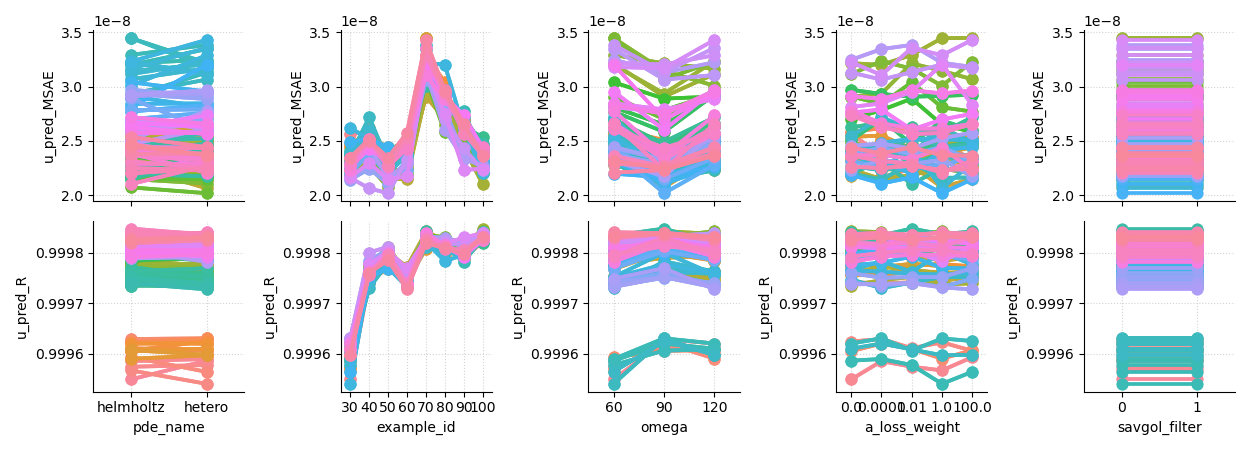

In [6]:
m = metrics.reset_index()

fig = ps.plot(
    m[(m.spatial_region == 'all') & (m.spatial_frequency_bin == 'all')].copy(),
    x=param_cols,
    y=['u_pred_MSAE', 'u_pred_R'],
    height=2.25,
    width=2.5,
    legend=False,
    tight=True
)

<IPython.core.display.Javascript object>


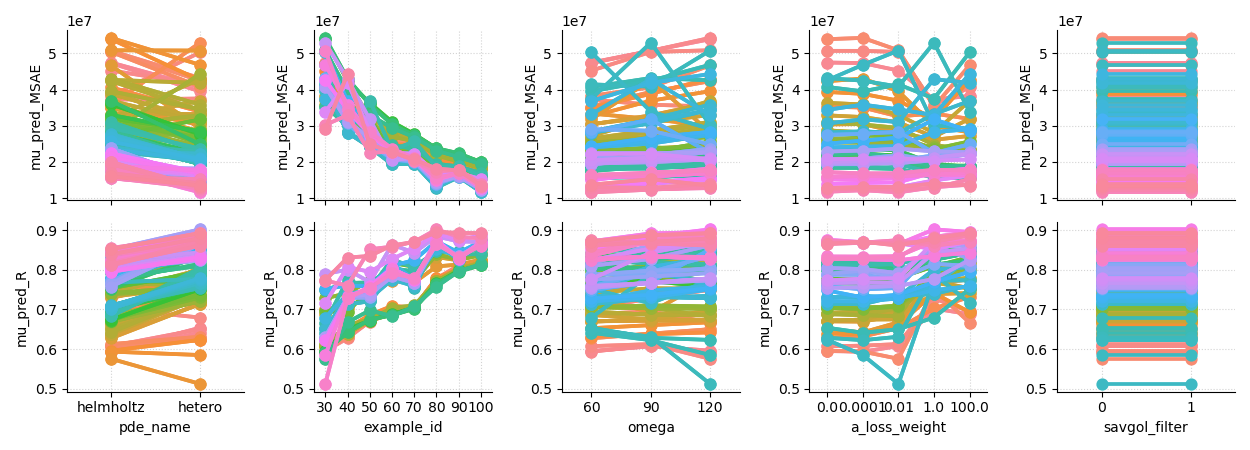

In [7]:
m = metrics.reset_index()

fig = ps.plot(
    m[(m.spatial_region == 'all') & (m.spatial_frequency_bin == 'all')].copy(),
    x=param_cols,
    y=['mu_pred_MSAE', 'mu_pred_R'],
    height=2.25,
    width=2.5,
    legend=False,
    tight=True
)

In [26]:
m['pde_abbrev'] = m.pde_name.map({'helmholtz': 'HH', 'hetero': 'het'}.__getitem__)
m['method'] = 'PINN-' + m['pde_abbrev']

ahi_m = m[m.pde_name == 'helmholtz'].copy()
ahi_m['method'] = 'AHI'
for col in m.columns:
    if col.startswith('direct'):
        ahi_m[col.replace('direct', 'mu')] = m[col]
        
fem_m = m.copy()
fem_m['method'] = 'FEM-' + m['pde_abbrev']
for col in m.columns:
    if col.startswith('fem'):
        fem_m[col.replace('fem', 'mu')] = m[col]
        
mm = pd.concat([ahi_m, fem_m, m])

method_order = ['AHI', 'FEM-HH', 'FEM-het', 'PINN-HH', 'PINN-het']
region_order = ['all', '0', '1', '2', '3', '4', '5']
mm['method_index'] = mm['method'].map(method_order.index)
mm['region_index'] = mm['spatial_region'].map(region_order.index)
mm = mm.sort_values('method_index')

In [27]:
import matplotlib as mpl
pct_format = mpl.ticker.PercentFormatter()

mm['mu_pred_MSAE_relative'] = mm['mu_pred_MSAE'] / mm['mu_true_MSAV'] * 100
mm['mu_pred_MAD_relative'] = mm['mu_pred_MAD'] / mm['mu_true_MAV'] * 100
mm['mu_pred_PSD_relative'] = mm['mu_diff_PSD'] / mm['mu_true_PSD'] * 100

In [28]:
%autoreload
import seaborn as sns
import matplotlib.pyplot as plt

colors = ps.results.get_color_palette(10, type='deep', min_val=0)
blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = colors

colors = [red, yellow, green, cyan, blue]
sns.set_palette(colors)
colors = sns.color_palette()
colors

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]

In [29]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023'

<IPython.core.display.Javascript object>


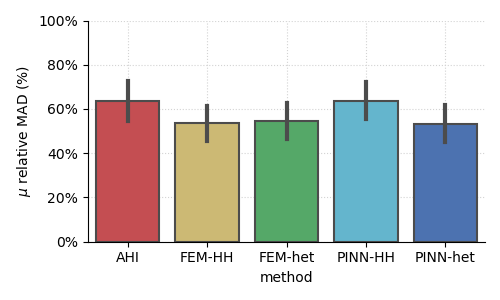

In [30]:
fig = ps.plot(
    mm[
        (mm.spatial_region != 'all') &
        (mm.spatial_region != '0') &
        ~mm.savgol_filter &
        (mm.omega == 60) &
        (mm.a_loss_weight == 0)
    ].copy(), 
    x='method',
    hue='method',
    y='mu_pred_MAD_relative',
    height=3,
    width=5,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].set_ylim(0, 100)
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/phantom_method_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [31]:
mm[
    (mm.spatial_region != 'all') &
    (mm.spatial_region != '0') &
    ~mm.savgol_filter &
    (mm.omega == 60) &
    (mm.a_loss_weight == 0)
].groupby(['method'])[['mu_pred_MAD_relative']].describe()

mu_pred_MAD_relative                                              \
                        count       mean        std        min        25%   
method                                                                      
AHI                      40.0  63.642351  30.210417  22.586816  33.632833   
FEM-HH                   40.0  53.684406  25.942973  16.355487  31.569819   
FEM-het                  40.0  54.375094  27.288267  13.752610  31.522769   
PINN-HH                  40.0  63.428994  27.986214  24.154578  34.917312   
PINN-het                 40.0  53.131298  27.147514  15.728541  29.712032   

                                            
                50%        75%         max  
method                                      
AHI       58.429497  94.847954  114.451135  
FEM-HH    46.655542  76.497290   99.039524  
FEM-het   46.615821  77.157520   98.914905  
PINN-HH   60.886921  88.636312  104.510300  
PINN-het  43.920384  78.691276   98.768133

<IPython.core.display.Javascript object>


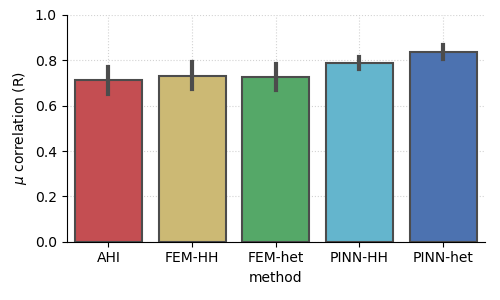

In [32]:
fig = ps.plot(
    mm[
        (mm.spatial_region == 'all') &
        (mm.spatial_frequency_bin == 'all') &
        ~mm.savgol_filter &
        (mm.omega == 90) &
        (mm.a_loss_weight == 1e0)
    ].copy(),
    x='method',
    hue='method',
    y='mu_pred_R',
    height=3,
    width=5,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ correlation (R)')
fig.axes[0].set_ylim([0, 1])

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/phantom_method_R_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [36]:
mm[
    (mm.spatial_region == 'all') &
    (mm.spatial_frequency_bin == 'all') &
    ~mm.savgol_filter &
    (mm.omega == 60) &
    (mm.a_loss_weight == 0)
].groupby(['method'])[['mu_pred_R']].describe()

mu_pred_R                                                    \
             count      mean       std       min       25%       50%   
method                                                                 
AHI            8.0  0.712823  0.088593  0.561163  0.662285  0.721971   
FEM-HH         8.0  0.731365  0.093597  0.601314  0.657947  0.744226   
FEM-het        8.0  0.725278  0.085599  0.600988  0.661556  0.727142   
PINN-HH        8.0  0.712288  0.083552  0.595138  0.659394  0.698787   
PINN-het       8.0  0.775346  0.078931  0.653874  0.719046  0.770774   

                              
               75%       max  
method                        
AHI       0.789727  0.808728  
FEM-HH    0.803929  0.840322  
FEM-het   0.793006  0.851226  
PINN-HH   0.784688  0.822778  
PINN-het  0.838944  0.873355

In [43]:
# contrast metrics
mmm = mm[
    (mm.spatial_frequency_bin == 'all') &
    (mm.spatial_region != 'all')
]
regions = mmm.spatial_region.unique()
mmm = mmm.set_index(index_cols[2:] + param_cols + ['method'])
mmm = mmm.unstack(level=0)
for r in regions:
    mmm['mu_pred_MAC', r] = mmm['mu_pred_MAV', r] - mmm['mu_pred_MAV', '1']
    mmm['mu_true_MAC', r] = mmm['mu_true_MAV', r] - mmm['mu_true_MAV', '1']

mmm = mmm.stack().reset_index().sort_values(['method_index', 'region_index'])
mmm['mu_pred_CTE'] = mmm['mu_pred_MAC'].abs() / mmm['mu_true_MAC'].abs() * 100
mmm

,pde_name,example_id,omega,a_loss_weight,savgol_filter,method,spatial_region,Lu_true_MAV,Lu_true_MSAV,Lu_true_PSD,...,u_pred_MAV,u_pred_MSAE,u_pred_MSAV,u_pred_PSD,u_pred_R,u_true_MAV,u_true_MSAV,u_true_PSD,u_true_R,mu_pred_CTE
0,helmholtz,30,60,0.0000,0,AHI,0,0.000000,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,39.070676
18,helmholtz,30,60,0.0000,1,AHI,0,0.000000,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,39.070676
36,helmholtz,30,60,0.0001,0,AHI,0,0.000000,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,39.070676
54,helmholtz,30,60,0.0001,1,AHI,0,0.000000,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,39.070676
72,helmholtz,30,60,0.0100,0,AHI,0,0.000000,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,39.070676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7151,hetero,100,120,0.0100,1,PINN-het,5,306.000185,NaN,NaN,...,0.007792,NaN,NaN,NaN,NaN,0.007821,NaN,NaN,NaN,60.260775
7163,hetero,100,120,1.0000,0,PINN-het,5,306.000185,NaN,NaN,...,0.007798,NaN,NaN,NaN,NaN,0.007821,NaN,NaN,NaN,23.683126
7175,hetero,100,120,1.0000,1,PINN-het,5,306.000185,NaN,NaN,...,0.007798,NaN,NaN,NaN,NaN,0.007821,NaN,NaN,NaN,23.683126
7187,hetero,100,120,100.0000,0,PINN-het,5,306.000185,NaN,NaN,...,0.007861,NaN,NaN,NaN,NaN,0.007821,NaN,NaN,NaN,20.865668


<IPython.core.display.Javascript object>


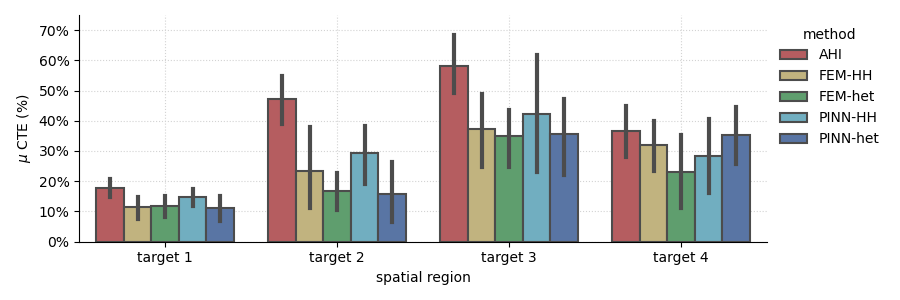

In [56]:
fig = ps.plot(
    mmm[
        (mmm.spatial_region.isin(set('2345'))) &
        (mmm.omega == 60) &
        (mmm.a_loss_weight == 0) &
        ~mmm.savgol_filter
    ],
    x='spatial_region',
    y='mu_pred_CTE',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylim(0, 75)
fig.axes[0].set_ylabel('$\mu$ CTE (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

fig.axes[0].set_xlabel('spatial region')
fig.axes[0].set_xticklabels(['target 1', 'target 2', 'target 3', 'target 4'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/pantom_contrast_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [46]:
mmm[
    (mmm.spatial_region.isin(set('2345'))) &
    (mmm.omega == 60) &
    (mmm.a_loss_weight == 0) &
    ~mmm.savgol_filter
].groupby(['spatial_region', 'method'])[['mu_pred_CTE']].describe()

mu_pred_CTE                                   \
                              count       mean        std        min   
spatial_region method                                                  
2              AHI              8.0  17.622021   4.436876  13.040361   
               FEM-HH           8.0  11.399504   5.812533   1.394687   
               FEM-het          8.0  11.787368   5.650628   0.209468   
               PINN-HH          8.0  14.598169   4.517451   6.102533   
               PINN-het         8.0  11.030737   6.664675   1.661819   
3              AHI              8.0  47.204671  12.654622  26.547841   
               FEM-HH           8.0  23.320118  20.493287   6.301042   
               FEM-het          8.0  16.604693   9.680548   5.724875   
               PINN-HH          8.0  29.393510  14.803539   2.471847   
               PINN-het         8.0  15.872870  15.007522   0.818891   
4              AHI              8.0  58.072376  14.761994  42.722093   
               FEM-HH           8.0  37.263514  18.427671   2.612398   
               FEM-het          8.0  34.881990  14.925283   5.226446   
               PINN-HH          8.0  42.151315  29.262635   6.457267   
               PINN-het         8.0  35.493116  19.572021   0.016068   
5              AHI              8.0  36.561945  13.151590  21.435471   
               FEM-HH           8.0  31.881047  12.616166  15.803476   
               FEM-het          8.0  22.915750  18.805901   1.460564   
               PINN-HH          8.0  28.235423  19.188438   2.926043   
               PINN-het         8.0  35.439123  15.032932  10.022181   

                                                                     
                               25%        50%        75%        max  
spatial_region method                                                
2              AHI       13.409286  16.951283  21.899790  23.161078  
               FEM-HH     8.129019  12.830051  14.586095  20.095436  
               FEM-het   10.062489  13.360194  15.460835  17.674519  
               PINN-HH   12.584455  15.392546  16.898046  20.603087  
               PINN-het   6.183944  13.116077  15.630604  19.044234  
3              AHI       42.425314  49.243170  55.490147  63.737651  
               FEM-HH    11.543584  15.459063  25.221369  64.012561  
               FEM-het    9.993170  13.321222  22.606406  34.264745  
               PINN-HH   23.252091  29.532233  38.401613  49.374151  
               PINN-het   3.584394  11.137377  28.091685  41.246569  
4              AHI       43.916336  56.178303  68.773258  82.212774  
               FEM-HH    32.226362  35.688654  48.095552  62.551873  
               FEM-het   28.347233  37.979715  43.851554  53.812521  
               PINN-HH   11.855270  48.716534  67.265922  74.136618  
               PINN-het  28.180968  39.914073  47.546626  58.119005  
5              AHI       25.600607  36.194499  43.282041  58.709944  
               FEM-HH    19.187056  36.954808  40.202413  47.497053  
               FEM-het    9.033597  23.160815  28.701310  57.401396  
               PINN-HH   12.866607  31.102429  41.801881  55.276007  
               PINN-het  25.337494  38.480043  45.668358  54.386426

<IPython.core.display.Javascript object>


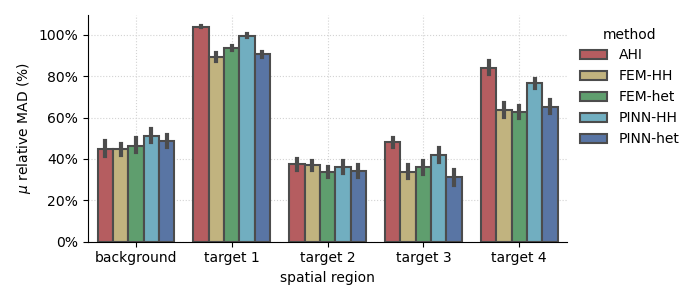

In [49]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.spatial_region != '0') & ~mm.savgol_filter],
    x='spatial_region',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=7,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

fig.axes[0].set_xlabel('spatial region')
fig.axes[0].set_xticklabels(['background', 'target 1', 'target 2', 'target 3', 'target 4'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/phantom_region_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [50]:
mm[['omega', 'spatial_frequency_bin', 'mu_pred_PSD']]

,omega,spatial_frequency_bin,mu_pred_PSD
0,60,all,NaN
2712,60,3.0,5.706726e+07
2713,60,4.0,2.607904e+07
2714,60,5.0,1.099833e+07
2715,60,6.0,5.983293e+06
...,...,...,...
5444,120,all,NaN
5445,120,all,NaN
5446,120,all,NaN
5433,90,4.0,7.983759e+06


<IPython.core.display.Javascript object>


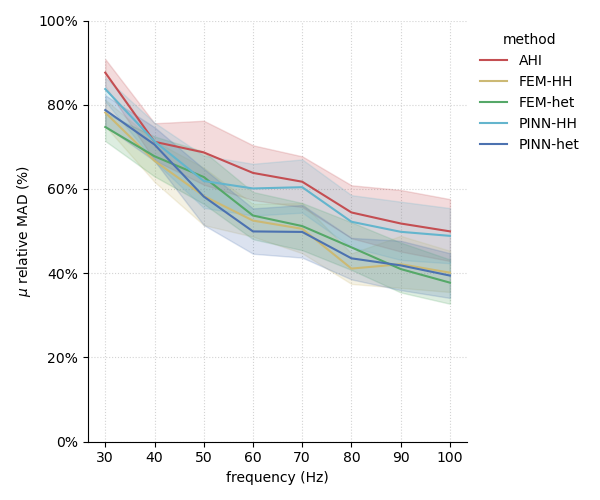

In [54]:
fig = ps.plot(
    mm[~mm.spatial_region.isin({'0', 'all'}) & ~mm.savgol_filter],
    x='example_id',
    y='mu_pred_MAD_relative',
    hue='method',
    height=5,
    width=6,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.axes[0].set_ylim(0, 100)
fig.tight_layout()

fig.axes[0].set_xlabel('frequency (Hz)')

for ext in ['png', 'pdf']:
    fig.savefig(f'images/phantom_frequency_line_plot.{ext}', bbox_inches='tight', dpi=200)

In [52]:
mm.omega.unique()

array([ 60,  90, 120])

<IPython.core.display.Javascript object>


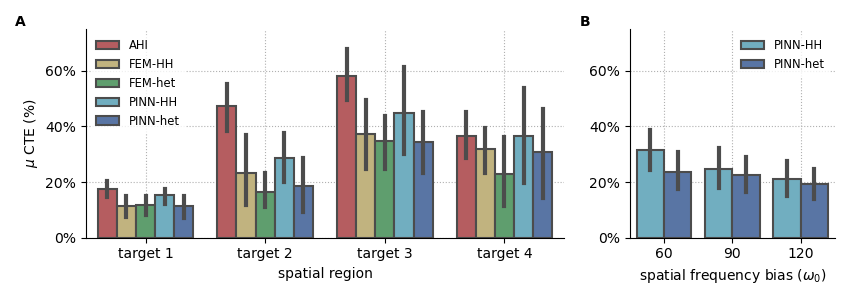

1.5
1.5


In [91]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3), width_ratios=(0.7, 0.3), squeeze=False)

sns.set_palette(colors)
ps.results.barplot(
    mmm[
        (mmm.spatial_region.isin(set('2345'))) &
        (mmm.omega == 60) &
        (mmm.a_loss_weight == 1e-2) &
        ~mmm.savgol_filter
    ],
    x='spatial_region',
    y='mu_pred_CTE',
    hue='method',
    ax=ax[0,0]
)
ax[0,0].grid(linestyle=':')
ax[0,0].axes.set_axisbelow(True)
ax[0,0].legend(frameon=True, fontsize='small', loc='upper left', ncol=1, edgecolor='w')

t = mpl.transforms.ScaledTranslation(-0.6, 0, fig.dpi_scale_trans)
ax[0,0].text(
    0, 1, 'A', fontweight='bold', va='bottom', ha='right',
    transform=ax[0,0].transAxes + t
)

ax[0,0].set_ylabel('$\mu$ CTE (%)')
ax[0,0].set_ylim(0, 75)
ax[0,0].yaxis.set_major_formatter(pct_format)

ax[0,0].set_xlabel('spatial region')
ax[0,0].set_xticklabels([ 'target 1', 'target 2', 'target 3', 'target 4'])

sns.set_palette(colors[-2:])
ps.results.barplot(
    mmm[
        (mmm.spatial_region.isin(set('2345'))) &
        (mmm.a_loss_weight == 1e-2) &
        ~mmm.savgol_filter &
        mmm.method.str.startswith('PINN')
    ],
    x='omega',
    y='mu_pred_CTE',
    hue='method',
    ax=ax[0,1]
)
ax[0,1].grid(linestyle=':')
ax[0,1].axes.set_axisbelow(True)
for p in ax[0,1].legend(frameon=True, edgecolor='w', fontsize='small').get_patches():
    print(p.get_linewidth())

t = mpl.transforms.ScaledTranslation(-0.4, 0, fig.dpi_scale_trans)
ax[0,1].text(0, 1, 'B', fontweight='bold', va='bottom', ha='right', transform=ax[0,1].transAxes + t)

ax[0,1].set_ylabel(None)
ax[0,1].set_ylim(0, 75)
ax[0,1].yaxis.set_major_formatter(pct_format)

ax[0,1].set_xlabel('spatial frequency bias ($\omega_0$)')

sns.despine(fig)
fig.tight_layout()

for ext in ['png', 'pdf']:
    fig.savefig(f'images/phantom_plots.{ext}', bbox_inches='tight', dpi=200)

In [81]:
mmm[
    (mmm.spatial_region.isin(set('2345'))) &
    (mmm.omega == 60) &
    (mmm.a_loss_weight == 0) &
    ~mmm.savgol_filter
].groupby(['method', 'spatial_region'])[['mu_pred_CTE']].describe()

mu_pred_CTE                                   \
                              count       mean        std        min   
method   spatial_region                                                
AHI      2                      8.0  17.622021   4.436876  13.040361   
         3                      8.0  47.204671  12.654622  26.547841   
         4                      8.0  58.072376  14.761994  42.722093   
         5                      8.0  36.561945  13.151590  21.435471   
FEM-HH   2                      8.0  11.399504   5.812533   1.394687   
         3                      8.0  23.320118  20.493287   6.301042   
         4                      8.0  37.263514  18.427671   2.612398   
         5                      8.0  31.881047  12.616166  15.803476   
FEM-het  2                      8.0  11.787368   5.650628   0.209468   
         3                      8.0  16.604693   9.680548   5.724875   
         4                      8.0  34.881990  14.925283   5.226446   
         5                      8.0  22.915750  18.805901   1.460564   
PINN-HH  2                      8.0  14.598169   4.517451   6.102533   
         3                      8.0  29.393510  14.803539   2.471847   
         4                      8.0  42.151315  29.262635   6.457267   
         5                      8.0  28.235423  19.188438   2.926043   
PINN-het 2                      8.0  11.030737   6.664675   1.661819   
         3                      8.0  15.872870  15.007522   0.818891   
         4                      8.0  35.493116  19.572021   0.016068   
         5                      8.0  35.439123  15.032932  10.022181   

                                                                     
                               25%        50%        75%        max  
method   spatial_region                                              
AHI      2               13.409286  16.951283  21.899790  23.161078  
         3               42.425314  49.243170  55.490147  63.737651  
         4               43.916336  56.178303  68.773258  82.212774  
         5               25.600607  36.194499  43.282041  58.709944  
FEM-HH   2                8.129019  12.830051  14.586095  20.095436  
         3               11.543584  15.459063  25.221369  64.012561  
         4               32.226362  35.688654  48.095552  62.551873  
         5               19.187056  36.954808  40.202413  47.497053  
FEM-het  2               10.062489  13.360194  15.460835  17.674519  
         3                9.993170  13.321222  22.606406  34.264745  
         4               28.347233  37.979715  43.851554  53.812521  
         5                9.033597  23.160815  28.701310  57.401396  
PINN-HH  2               12.584455  15.392546  16.898046  20.603087  
         3               23.252091  29.532233  38.401613  49.374151  
         4               11.855270  48.716534  67.265922  74.136618  
         5               12.866607  31.102429  41.801881  55.276007  
PINN-het 2                6.183944  13.116077  15.630604  19.044234  
         3                3.584394  11.137377  28.091685  41.246569  
         4               28.180968  39.914073  47.546626  58.119005  
         5               25.337494  38.480043  45.668358  54.386426

In [87]:
mmm[
    (mmm.spatial_region.isin(set('2345'))) &
    (mmm.a_loss_weight == 1e-2) &
    ~mmm.savgol_filter &
    mmm.method.str.startswith('PINN')
].groupby(['method', 'omega'])[['mu_pred_CTE']].describe()

mu_pred_CTE                                             \
                     count       mean        std       min        25%   
method   omega                                                          
PINN-HH  60           32.0  31.375162  21.366167  6.239111  15.324512   
         90           32.0  24.858841  20.272170  0.949079   9.753389   
         120          32.0  20.999714  18.347590  0.138546   5.550047   
PINN-het 60           32.0  23.759779  18.948284  0.748704   7.908430   
         90           32.0  22.398518  18.493988  0.486568   8.124898   
         120          32.0  19.161306  16.223699  0.195287   6.631206   

                                                 
                      50%        75%        max  
method   omega                                   
PINN-HH  60     20.984027  51.823962  70.075772  
         90     17.047027  37.000747  63.745500  
         120    14.755534  36.770869  58.303059  
PINN-het 60     18.245447  35.066058  76.662540  
         90     15.698376  33.375410  67.138956  
         120    14.340473  25.782819  60.260775

<IPython.core.display.Javascript object>


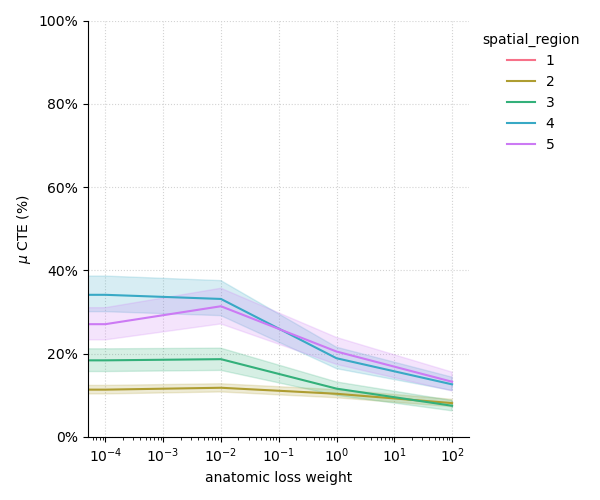

In [86]:
fig = ps.plot(
    mmm[~mmm.spatial_region.isin({'0', 'all'}) & mmm.method.str.startswith('PINN')], 
    x='a_loss_weight',
    y='mu_pred_CTE',
    hue='spatial_region',
    height=5,
    width=6,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
fig.axes[0].set_ylabel('$\mu$ CTE (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.axes[0].set_ylim(0, 100)
fig.axes[0].set_xscale('log')
fig.tight_layout()

fig.axes[0].set_xlabel('anatomic loss weight')

for ext in ['png', 'pdf']:
    fig.savefig(f'images/phantom_anat_line_plot.{ext}', bbox_inches='tight', dpi=200)

In [92]:
%autoreload

blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = sns.color_palette('tab10')

mre_pinn.visual.COLORS.update(
    red=red,
    yellow=yellow,
    green=green,
    cyan=cyan,
    blue=blue
)

In [ ]:
dataset = mre_pinn.data.MREDataset.load_xarrays(
    xarray_dir='../data/BIOQIC/phantom'
)

<IPython.core.display.Javascript object>


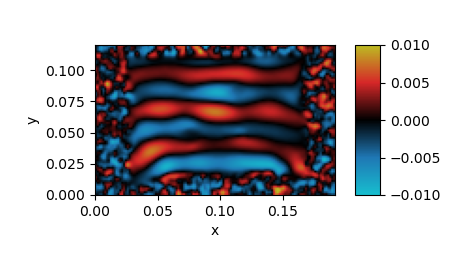

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



<IPython.core.display.Javascript object>


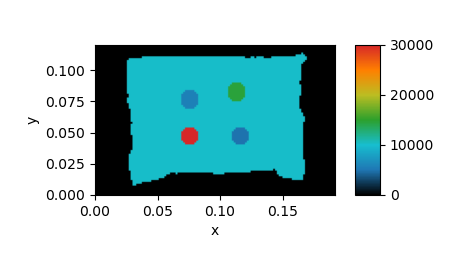

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



In [120]:
wave_kws  = dict(vmin=-1e-2, vmax=1e-2, cmap=mre_pinn.visual.wave_color_map())
elast_kws = dict(vmin=0, vmax=3e4, cmap=mre_pinn.visual.mre_color_map(symmetric=False))

dataset[0].view('wave', ax_height=1.5, space=0.2, **wave_kws)
plt.gcf().tight_layout()
plt.savefig('images/phantom_regions.png', dpi=200, bbox_inches='tight')

dataset[0].view('mre', ax_height=1.5, space=0.2, **elast_kws)
plt.gcf().tight_layout()
plt.savefig('images/phantom_mre.png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


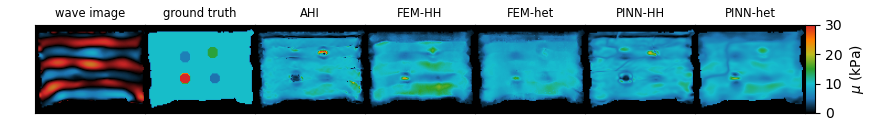

Loading ../data/BIOQIC/phantom/100/wave.nc
Loading ../data/BIOQIC/phantom/100/mre.nc
Loading ../data/BIOQIC/phantom/100/mre_mask.nc
Loading 2023-2-26_phantom_FEM/train_phantom_100_0_helmholtz/train_phantom_100_0_helmholtz_direct.nc
Loading 2023-2-26_phantom_FEM/train_phantom_100_0_helmholtz/train_phantom_100_0_helmholtz_fem.nc
Loading 2023-2-26_phantom_FEM/train_phantom_100_0_hetero/train_phantom_100_0_hetero_fem.nc
Loading 2022-2-7_phantom_anat2/train_phantom_100_60_helmholtz_1e-02/train_phantom_100_60_helmholtz_1e-02_elastogram.nc
Loading 2022-2-7_phantom_anat2/train_phantom_100_60_hetero_1e-02/train_phantom_100_60_hetero_1e-02_elastogram.nc


In [125]:
%autoreload
import mre_pinn

# wave images

image_names = [
    'wave image', 'ground truth', 'AHI', 'FEM-HH', 'FEM-het', 'PINN-HH', 'PINN-het'
]

pinn_expt_name = '2022-2-7_phantom_anat2'
pinn_job_name = 'train_phantom_{example_id}_{omega}_{pde_name}_{a_loss_weight:.0e}'

fem_expt_name = '2023-2-26_phantom_FEM'
fem_job_name = 'train_phantom_{example_id}_{savgol_filter}_{pde_name}'

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1.1
    ax_height = ax_width * 80 / 100
    cbar_width = 0.1
    
    omega = 60
    a_loss_weight = 1e-2
    savgol_filter = 0
    vmax = 3e4

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(
        n_rows, n_cols, ax_height, ax_width, cbar_width, space=0, pad=(0.35,0.55,0.15,0.25)
    )
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/phantom', example_id)
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0 and False:
                ax.set_ylabel(example_id + ' Hz', fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])

            if image_name == 'wave image':
                array = example.wave.sel(component='z')[...,0]
                color_kws = wave_kws
                array = array.real * (example.mre_mask.values[...,0] > 0)

            elif image_name == 'ground truth':
                array = example.mre[...,0]
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'AHI':
                job_name = fem_job_name.format(
                    example_id=example_id, pde_name='helmholtz', savgol_filter=savgol_filter
                )
                nc_file = f'{fem_expt_name}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array.real)
                
            elif image_name == 'FEM-HH':
                job_name = fem_job_name.format(
                    example_id=example_id, pde_name='helmholtz', savgol_filter=savgol_filter
                )
                nc_file = f'{fem_expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'FEM-het':
                job_name = fem_job_name.format(
                    example_id=example_id, pde_name='hetero', savgol_filter=savgol_filter
                )
                nc_file = f'{fem_expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'PINN-HH':
                job_name = pinn_job_name.format(
                    example_id=example_id, pde_name='helmholtz', omega=omega, a_loss_weight=a_loss_weight
                )
                nc_file = f'{pinn_expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'PINN-het':
                job_name = pinn_job_name.format(
                    example_id=example_id, pde_name='hetero', omega=omega, a_loss_weight=a_loss_weight
                )
                nc_file = f'{pinn_expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            im = mre_pinn.visual.imshow(ax, array[14:-14], **color_kws)
            
    plt.colorbar(im, cax=cbar_ax)
    cbar_ax.set_yticks([0, 1e4, 2e4, 3e4])
    cbar_ax.set_yticklabels(['0', '10', '20', '30'])
    cbar_ax.set_ylabel('$\mu$ (kPa)')
    return fig

fig = plot_image_grid(['30', '40', '50', '60', '70', '80', '90', '100'][-1:])
#fig0 = plot_image_grid(['30', '40', '50', '60'])
#fig1 = plot_image_grid(['70', '80', '90', '100'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/phantom_wave_grid.{ext}', bbox_inches='tight', dpi=200)
    #fig0.savefig(f'images/phantom_wave_grid0.{ext}', bbox_inches='tight', dpi=200)
    #fig1.savefig(f'images/phantom_wave_grid1.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


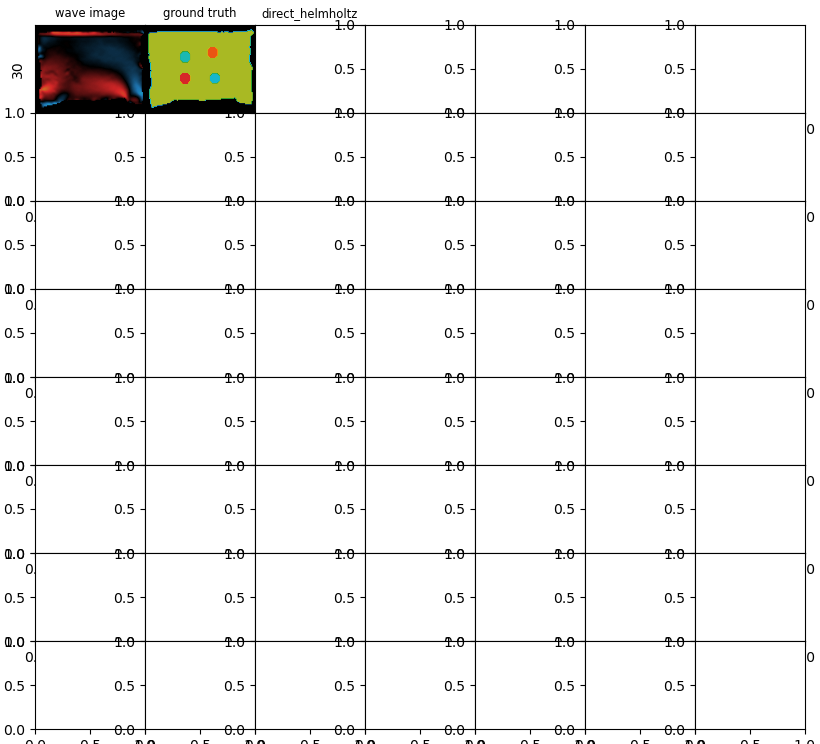

Loading ../data/BIOQIC/phantom/30/wave.nc
Loading ../data/BIOQIC/phantom/30/mre.nc
Loading ../data/BIOQIC/phantom/30/mre_mask.nc


NameError: name 'name' is not defined

In [122]:
%autoreload
import mre_pinn

image_names = ['wave image', 'ground truth', 'direct_helmholtz', 'FEM_helmholtz', 'FEM_hetero', 'PINN_helmholtz', 'PINN_hetero']

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1.1
    ax_height = ax_width * 80 / 100
    
    data_name = 'phantom'
    omega = 30

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/phantom', example_id)
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0:
                ax.set_ylabel(example_id, fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])

            if image_name == 'wave image':
                array = example.wave.sel(component='z')[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = array.real * (example.mre_mask.values[...,0] > 0)

            elif image_name == 'ground truth':
                array = example.mre[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'direct_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', omega=omega
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)
                
            elif image_name == 'FEM_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', omega=omega
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'FEM_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', omega=omega
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', omega=omega
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', omega=omega
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            mre_pinn.visual.imshow(ax, array[14:-14], **color_kws)
    return fig

fig = plot_image_grid(['30', '40', '50', '60', '70', '80', '90', '100'])
#fig0 = plot_image_grid(['30', '40', '50', '60'])
#fig1 = plot_image_grid(['70', '80', '90', '100'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/phantom_example_grid.{ext}', bbox_inches='tight', dpi=200)
    #fig0.savefig(f'images/phantom_example_grid0.{ext}', bbox_inches='tight', dpi=200)
    #fig1.savefig(f'images/phantom_example_grid1.{ext}', bbox_inches='tight', dpi=200)

In [ ]:
%autoreload
import mre_pinn

image_names = [
    'ground truth',
    'FEM_helmholtz',
    'FEM_hetero',
    'direct_helmholtz',
    'PINN_helmholtz',
    'PINN_hetero'
]

def plot_image_grid(example_ids, omegas):
    n_rows = len(omegas)
    n_cols = len(image_names)
    ax_width = 2
    ax_height = ax_width * 80 / 100
    
    data_name = 'phantom'

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))

    for col_idx, image_name in enumerate(image_names):
        for row_idx, omega in enumerate(omegas):
            mean_array = 0
            for example_id in example_ids:
                example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/phantom', example_id)
                ax = axes[row_idx,col_idx]
                #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
                if col_idx == 0:
                    ax.set_ylabel(str(omega), fontsize='medium')
                if row_idx == 0:
                    ax.set_title(image_name, fontsize='small')
                ax.set_yticks([])
                ax.set_xticks([])

                if image_name == 'wave image':
                    array = example.wave.sel(component='z')[...,0]
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = array.real * (example.mre_mask.values[...,0] > 0)

                elif image_name == 'ground truth':
                    array = example.mre[...,0]
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'direct_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', omega=omega
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'FEM_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', omega=omega
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'FEM_hetero':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='hetero', omega=omega
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'PINN_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', omega=omega
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'PINN_hetero':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='hetero', omega=omega
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)
                    
                mean_array += array / len(example_ids)

            #color_kws['vmax'] = 2e4
            #color_kws['vmin'] = -color_kws['vmax']
            mre_pinn.visual.imshow(ax, mean_array[14:-14], **color_kws)
    return fig

fig = plot_image_grid(['30', '40', '50', '60', '70', '80', '90', '100'], [30])
#fig0 = plot_image_grid(['30', '40', '50', '60'])
#fig1 = plot_image_grid(['70', '80', '90', '100'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/phantom_multifreq_grid.{ext}', bbox_inches='tight', dpi=200)
    #fig0.savefig(f'images/phantom_example_grid0.{ext}', bbox_inches='tight', dpi=200)
    #fig1.savefig(f'images/phantom_example_grid1.{ext}', bbox_inches='tight', dpi=200)